In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Downloading the necessary libraries

In [ ]:
import os
import shutil
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
import itertools
import random
from sklearn.utils import class_weight
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.utils.multiclass import unique_labels
from collections import Counter
from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import timm
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


#Organizing the celeb-df data into its testing and training data as defined in the dataset manual

In [ ]:

# Paths
dataset_path = "/content/drive/My Drive/Colab Notebooks/CAPSTONE/"
testing_file = os.path.join(dataset_path, "List_of_testing_videos.txt")
output_testing_dir = os.path.join(dataset_path, "Testing")
output_training_dir = os.path.join(dataset_path, "Training")

# Creating output directories
os.makedirs(output_testing_dir, exist_ok=True)
os.makedirs(output_training_dir, exist_ok=True)


In [ ]:

# Reading the testing video list
with open(testing_file, 'r') as f:
    testing_videos = f.read().splitlines()


testing_videos = [os.path.basename(video.strip()) for video in testing_videos]


print(testing_videos)

['00170.mp4', '00208.mp4', '00063.mp4', '00024.mp4', '00021.mp4', '00036.mp4', '00202.mp4', '00236.mp4', '00197.mp4', '00133.mp4', '00213.mp4', '00011.mp4', '00095.mp4', '00138.mp4', '00106.mp4', '00194.mp4', '00092.mp4', '00227.mp4', '00244.mp4', '00119.mp4', '00082.mp4', '00188.mp4', '00076.mp4', '00047.mp4', '00168.mp4', '00207.mp4', '00193.mp4', '00061.mp4', '00023.mp4', '00048.mp4', '00250.mp4', '00251.mp4', '00252.mp4', '00253.mp4', '00254.mp4', '00255.mp4', '00256.mp4', '00257.mp4', '00258.mp4', '00259.mp4', '00260.mp4', '00261.mp4', '00262.mp4', '00263.mp4', '00264.mp4', '00265.mp4', '00266.mp4', '00267.mp4', '00268.mp4', '00269.mp4', '00270.mp4', '00271.mp4', '00272.mp4', '00273.mp4', '00274.mp4', '00275.mp4', '00276.mp4', '00277.mp4', '00278.mp4', '00279.mp4', '00280.mp4', '00281.mp4', '00282.mp4', '00283.mp4', '00284.mp4', '00285.mp4', '00286.mp4', '00287.mp4', '00288.mp4', '00289.mp4', 'id1_0007.mp4', 'id2_0008.mp4', 'id3_0001.mp4', 'id6_0005.mp4', 'id9_0000.mp4', 'id11_000

In [ ]:

for folder in ["Celeb-real"]:
    folder_path = os.path.join(dataset_path, folder)
    for video in os.listdir(folder_path):
        video_path = os.path.join(folder_path, video)


        if video in testing_videos:
            destination = os.path.join(output_testing_dir, video)
        else:
            destination = os.path.join(output_training_dir, video)

        # Checking if file already exists before moving
        if not os.path.exists(destination):
            shutil.move(video_path, destination)

print(f"Testing videos moved to: {output_testing_dir}")
print(f"Training videos moved to: {output_training_dir}")



Testing videos moved to: /content/drive/My Drive/Colab Notebooks/CAPSTONE/Testing
Training videos moved to: /content/drive/My Drive/Colab Notebooks/CAPSTONE/Training


In [ ]:

for folder in ["YouTube-real"]:
    folder_path = os.path.join(dataset_path, folder)
    for video in os.listdir(folder_path):
        video_path = os.path.join(folder_path, video)


        if video in testing_videos:
            destination = os.path.join(output_testing_dir, video)
        else:
            destination = os.path.join(output_training_dir, video)

        # Checking if file already exists before moving
        if not os.path.exists(destination):
            shutil.move(video_path, destination)

print(f"Testing videos moved to: {output_testing_dir}")
print(f"Training videos moved to: {output_training_dir}")

Testing videos moved to: /content/drive/My Drive/Colab Notebooks/CAPSTONE/Testing
Training videos moved to: /content/drive/My Drive/Colab Notebooks/CAPSTONE/Training


In [ ]:
import os
import shutil

fake_count = 1  # Counter to ensure unique filenames

for folder in ["Celeb-synthesis"]:
    folder_path = os.path.join(dataset_path, folder)

    for video in os.listdir(folder_path):
        video_path = os.path.join(folder_path, video)


        _, video_ext = os.path.splitext(video)

        # Creating a new unique name for the fake video
        new_video_name = f"fake_{fake_count}{video_ext}"
        fake_count += 1

        # Defining the destination folder (testing or training)
        if video in testing_videos:
            destination = os.path.join(output_testing_dir, new_video_name)
        else:
            destination = os.path.join(output_training_dir, new_video_name)

        # Checking if file already exists before moving
        if not os.path.exists(destination):
            shutil.move(video_path, destination)

print(f"All videos in 'Celeb-synthesis' labeled as 'fake' and moved.")
print(f"Testing videos moved to: {output_testing_dir}")
print(f"Training videos moved to: {output_training_dir}")


All videos in 'Celeb-synthesis' labeled as 'fake' and moved.
Testing videos moved to: /content/drive/My Drive/Colab Notebooks/CAPSTONE/Testing
Training videos moved to: /content/drive/My Drive/Colab Notebooks/CAPSTONE/Training


##Labeling the data as real or fake videos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import os
# Function to determine if a video is real or fake
def get_label(video_name):
    if video_name.startswith("00") or video_name.startswith("000") or video_name.startswith("0000") or video_name.startswith("00000") or video_name.count('_') == 1:
        return "real"
    else:
        return "fake"



In [ ]:

# Paths
dataset_path = "/content/drive/My Drive/Colab Notebooks/CAPSTONE/"
testing_file = os.path.join(dataset_path, "List_of_testing_videos.txt")
output_testing_dir = os.path.join(dataset_path, "Testing")
output_training_dir = os.path.join(dataset_path, "Training")
fake_videos_dir = os.path.join(dataset_path, "Celeb-synthesis")

In [ ]:
# Defining the folders containing videos
folders = [output_training_dir, output_testing_dir]

for folder in folders:
    real_count = 1  # Counter for real videos
    fake_count = 1  # Counter for fake videos

    for video in os.listdir(folder):
        video_path = os.path.join(folder, video)

        # Ensuring it's valid a file before renaming
        if os.path.isfile(video_path):
            _, video_ext = os.path.splitext(video)  # Getting the file extension
            label = get_label(video)  # Determining the label

            # Assigning unique names with numbering
            if label == "real":
                new_video_name = f"real_{real_count}{video_ext}"
                real_count += 1
            else:
                new_video_name = f"fake_{fake_count}{video_ext}"
                fake_count += 1

            new_video_path = os.path.join(folder, new_video_name)

            # Renaming the file
            os.rename(video_path, new_video_path)

#Finding the number of real and fake videos in our training dataset

In [ ]:

# Initializing counters
real_videos = []
fake_videos = []

# Looping through all video files in the folder
for video in os.listdir(output_training_dir):
    if video.endswith((".mp4", ".avi", ".mov")):  # Filter video files
        # Classifying videos based on naming structure
        if video.startswith("real"):
            real_videos.append(video)
        else:
            fake_videos.append(video)

# Printing the Summary from the analysis
print("\n=== Dataset Summary ===")
print(f"Total Videos: {len(real_videos) + len(fake_videos)}")
print(f"Real Videos: {len(real_videos)}")
print(f"Fake Videos: {len(fake_videos)}")



=== Dataset Summary ===
Total Videos: 6011
Real Videos: 712
Fake Videos: 5299


#Finding the duration of the videos

In [ ]:

# Initializing counters
real_durations = []
fake_durations = []

# Loopping through all video files in the folder
for video in os.listdir(output_training_dir):
    if video.endswith((".mp4", ".avi", ".mov")):  # Filtering video files
        video_path = os.path.join(output_training_dir, video)

        # Openning a video to get duration
        cap = cv2.VideoCapture(video_path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        duration = frame_count / fps if fps > 0 else 0
        cap.release()

        # Categorizing and storing duration
        if video.startswith("real"):
            real_durations.append(duration)
        else:
            fake_durations.append(duration)

# Computing averages
average_real_duration = sum(real_durations) / len(real_durations) if real_durations else 0
average_fake_duration = sum(fake_durations) / len(fake_durations) if fake_durations else 0

# Printing results
print("\n=== Video Duration Statistics ===")
print(f"Average Real Video Duration: {average_real_duration:.2f} seconds")
print(f"Average Fake Video Duration: {average_fake_duration:.2f} seconds")



=== Video Duration Statistics ===
Average Real Video Duration: 13.52 seconds
Average Fake Video Duration: 12.52 seconds


#Extracting frames from the training dataset

In [ ]:
##Usinging parallel technique for faster execution
import multiprocessing
import os

# Defining paths

dataset_path = "/content/drive/My Drive/Colab Notebooks/CAPSTONE/"
output_training_dir = os.path.join(dataset_path, "Training")#Where the training data is
output_frames_dir = os.path.join(dataset_path, "TrainFrames")#Where to store the frames
os.makedirs(output_frames_dir, exist_ok=True)  # Creating the frame directory

frame_rate = 30  # Extracting every 30th frame



In [ ]:
import cv2
def extract_frames(video_file):
    """Extract frames from a single video."""
    video_path = os.path.join(output_training_dir, video_file)
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Skipping {video_file}: Cannot open file.")
        return

    frame_count = 0
    success, frame = cap.read()

    while success:
        if frame_count % frame_rate == 0:
            frame_filename = os.path.join(output_frames_dir, f"{video_file}_frame_{frame_count}.jpg")
            cv2.imwrite(frame_filename, frame)

        success, frame = cap.read()
        frame_count += 1

    cap.release()
    print(f"Extracted {frame_count // frame_rate} frames from {video_file}")

# Getting all video files
video_files = [video for video in os.listdir(output_training_dir) if video.endswith((".mp4", ".avi", ".mov"))]


num_workers = min(multiprocessing.cpu_count(), len(video_files))  # Use all available CPU cores
with multiprocessing.Pool(num_workers) as pool:
    pool.map(extract_frames, video_files)

print("Frame extraction complete!")


##Data visualization

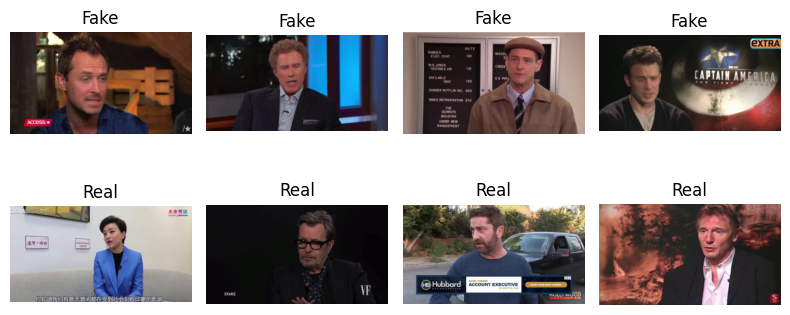

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import cv2  # OpenCV for image loading



# Initializing dictionaries for class names and frame paths
class_names = {"Fake": 0, "Real": 1}
frame_paths = {"Fake": [], "Real": []}

# Getting all frame file paths and classify them as Real or Fake
for filename in os.listdir(output_frames_dir):
    if filename.lower().startswith("real"):
        frame_paths["Real"].append(os.path.join(output_frames_dir, filename))
    elif filename.lower().startswith("fake"):
        frame_paths["Fake"].append(os.path.join(output_frames_dir, filename))

# Ensuring there are at least 4 frames per class
for class_name in frame_paths:
    if len(frame_paths[class_name]) < 4:
        print(f"Not enough frames in {class_name} category!")
        continue

# Randomly selecting 4 frames for each class
selected_frames = {
    class_name: random.sample(frame_paths[class_name], 4)
    for class_name in frame_paths if len(frame_paths[class_name]) >= 4
}

# Plotting selected frames
plt.figure(figsize=(8, 4))

for i, (class_name, frames) in enumerate(selected_frames.items()):
    for j, frame_path in enumerate(frames):
        img = cv2.imread(frame_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(2, 4, i * 4 + j + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

plt.tight_layout()
plt.show()


#Frequency of the data

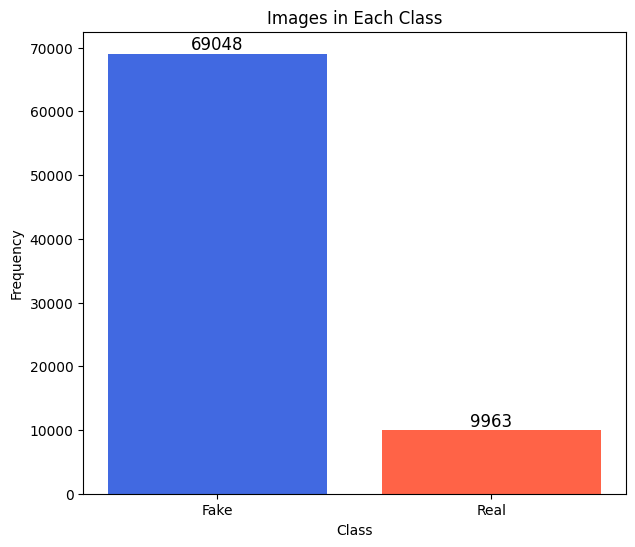

In [ ]:
import matplotlib.pyplot as plt

# Counting the number of frames per class
class_counts = {class_name: len(frame_list) for class_name, frame_list in frame_paths.items()}

# Defining custom colors for each class
colors = ['royalblue', 'tomato']

# Plotting the class frequencies
plt.figure(figsize=(7, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=colors)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Images in Each Class')

# Annotating bars with their frequencies
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(int(bar.get_height())),
             ha='center', va='bottom', fontsize=12)

plt.show()


#Loading the images and the labels of the images

In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split



# Defining image size 
IMG_SIZE = (128, 128)

# Initializing lists for data and labels
data = []
labels = []

# Loading images and labels
for filename in os.listdir(output_frames_dir):
    if filename.endswith(('.jpg', '.png')):
        file_path = os.path.join(output_frames_dir, filename)


        img = cv2.imread(file_path)
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        data.append(img)

        # Assigning labels based on filename
        if 'real' in filename.lower():
            labels.append(1)  # Label for "Real"
        elif 'fake' in filename.lower():
            labels.append(0)  # Label for "Fake"

# Converting to numpy arrays for easier manipulation
data = np.array(data, dtype=np.float32) / 255.0  # Normalizing pixel values between (0-1)
labels = np.array(labels, dtype=np.int32)


In [ ]:
print(len(data))

79011


In [ ]:

# Loading the saved data and labels
np.save("/content/drive/My Drive/Colab Notebooks/CAPSTONE/data.npy", data)  
np.save("/content/drive/My Drive/Colab Notebooks/CAPSTONE/labels.npy", labels)  
print("Data and labels saved successfully!")
print("Data and labels saved successfully!")



In [ ]:
np.save("/content/drive/My Drive/Colab Notebooks/CAPSTONE/data.npy", data)